# LIME aplicat a Models d'Entrenament Automàtic (ML), exemple Simple

## Inicialitzacions

### Imports i configuracions globalas
Eines i paquets típics i necessàris per al funcionament típic de programes Python

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
gray_cmap=LinearSegmentedColormap.from_list('gy',[(.3,.3,.3),(.8,.8,.8)], N=2)
np.random.seed(42) #Seed for random numbers generation

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression

In [16]:
def set_plot_style():
  plt.axis([-2,2,-2,2])
  plt.xlabel('x1')
  plt.ylabel('x2')

### Generar Base de Dades
Aquí s'utilitza un conjunt de dades artificial amb dues variables explicatives com a entrada i una variable binària categòrica com a sortida. Aquest conjunt de dades es va dissenyar manualment amb la intenció de representar un procés subyacent de generació de dades amb fronteres de decisió no lineals.
Es generarà un conjunt amb un cluster clar per fer visualitzacions més interessants.

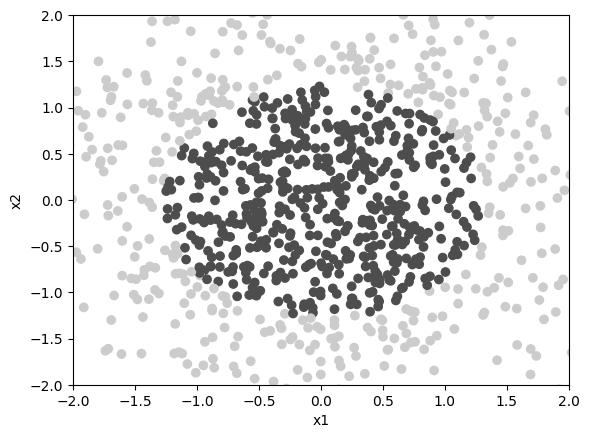

In [17]:
from sklearn.datasets import make_blobs

n_blobs = 1
# Generem dades per x1 i x2
np.random.seed(42)
num_samples = 1000
x1_values = np.random.uniform(-2, 2, num_samples)
x2_values = np.random.uniform(-2, 2, num_samples)

# Creem clusters per als valors de x1 i x2
X, _ = make_blobs(n_samples=num_samples, centers=n_blobs, random_state=42)

# Afegim una mica de soroll per als valors de x1 i x2
x1_values += X[:, 0]
x2_values += X[:, 1]

# Classifiquem els valors de y basant-nos en la distància als centroids dels clusters
centroids = np.mean(X, axis=0)
distances = np.linalg.norm(np.column_stack((x1_values, x2_values)) - centroids, axis=1)
y_values = (distances > np.mean(distances)).astype(int)

# Creem el DataFrame
df = pd.DataFrame({'x1': x1_values, 'x2': x2_values, 'y': y_values})
#display(df.head())

# Guardem els valors en X i y per a entrenar i estandaritzem les dades (bona praxis)
X = df[['x1','x2']].values
y = df['y'].values
X = (X - np.mean(X,axis=0)) / np.std(X,axis=0) #Standarization of data


# Mostrem les dades, el resultat és mapejar els valors y com a gris clar(y=0), gris fosc(y=1) a X1,X2
set_plot_style()
plt.scatter(X[:,0],X[:,1], c=y, cmap=gray_cmap)
plt.savefig('LIME_simplified_1.png')
plt.show()

### Entrenar un classificador d'aprenentatge automàtic
S'entrena un classificador RF amb les dades anteriors. (Recorda que aquest és un problema de classificació binària.)

In [5]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X, y)

RandomForestClassifier()

Es crea una malla per observar les fronteres de decisió del classificador entrenat. Si no estàs familiaritzat amb el concepte de malla o la representació de les fronteres de decisió, pots pensar-ho com a mostreig de molts valors de `x1` i `x2` en un rang específic i utilitzar el classificador d'aprenentatge automàtic per predir la sortida i observar visualment les fronteres de decisió del model entrenat. El gràfic que es mostra a continuació il·lustra les fronteres de decisió del classificador i es pot notar que són molt similars al procés subyacent de generació de dades. Tot i que sempre s'ha de controlar l'overfitting, en aquest cas no és necessàriament un problema perquè podem inferir visualment que les fronteres de decisió del classificador coincideixen amb el procés de generació de dades.

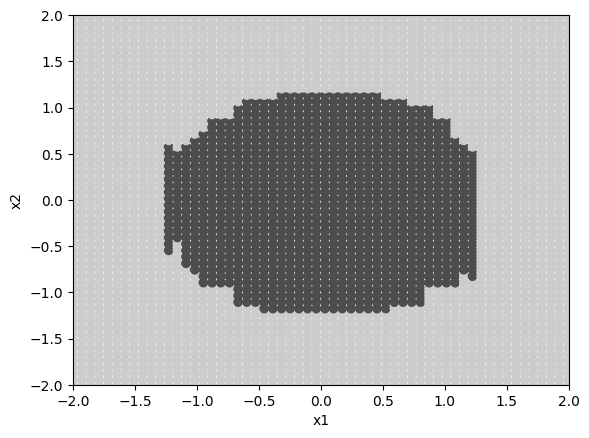

In [18]:
# Funció per crear una malla
def make_meshgrid(x1, x2, h=.02,x1_min=0,x1_max=0,x2_min=0,x2_max=0):
    if x1_min==0 and x1_max==0 and x2_min==0 and x2_max==0:
        x1_min, x1_max = x1.min() - 0.1, x1.max() + 0.1
        x2_min, x2_max = x2.min() - 0.1, x2.max() + 0.1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    return np.vstack((xx1.ravel(), xx2.ravel())).T

# Crea una malla i prediu la classe per a cada element de la malla
XX = make_meshgrid(X[:,0],X[:,1],h=.07)
yy = classifier.predict(XX)

set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.savefig('LIME_simplified_2.png')
plt.show()

## Explicacions LIME
LIME genera explicacions locals, és a dir, explicacions per a instàncies individuals en un conjunt de dades. LIME comença generant un nou conjunt de dades amb pertorbacions al voltant de la instància a explicar. Després, el classificador d'aprenentatge automàtic entrenat es fa servir per predir la classe de cada instància en el nou conjunt de dades generat. Finalment, s'ajusta un model més simple amb interpretabilitat intrínseca, com ara un model de regressió lineal, i s'utilitza per explicar la predicció del classificador. Abans d'ajustar un model més simple, les instàncies en el nou conjunt de dades generat es pesen en funció de la seva distància a la instància original que s'està explicant. D'aquesta manera, hi ha una major certesa que el model és localment fidel al voltant de la instància explicada.

En aquest exemple, com es mostra al gràfic següent, volem explicar la predicció del punt blau (instància amb x1 = 1 i x2 = -0,7).

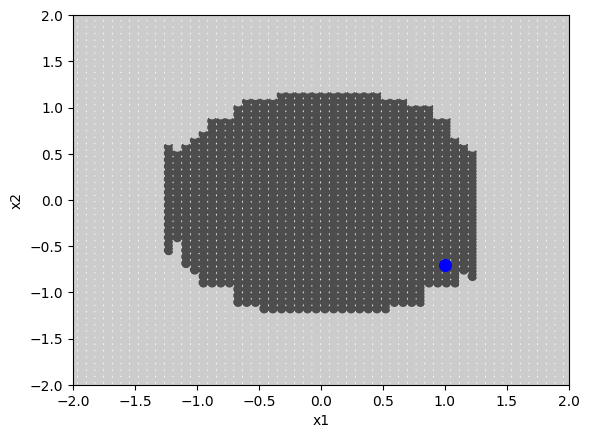

In [19]:
Xi = np.array([1,-0.7])
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )
plt.savefig('LIME_simplified_3.png')
plt.show()

### Pas 1. Generar pertorbacions aleatòries al voltant de la instància a explicar
Pel cas de dades tabulars, es recomana fer mostreig al voltant de la mitjana i la desviació estàndard de les variables explicatives. Donat que el conjunt de dades utilitzat en aquest exemple ja havia estat estandarditzat normalment en un pas anterior, es genera i emmagatzema una mostra aleatòria normal amb mitjana 0 i desviació estàndard 1 a la matriu 2D `X_lime`, com es mostra a continuació. En aquest punt, encara no sabem la classe per a cada element d'aquesta mostra. Aquesta classe es prediu en el pas següent.

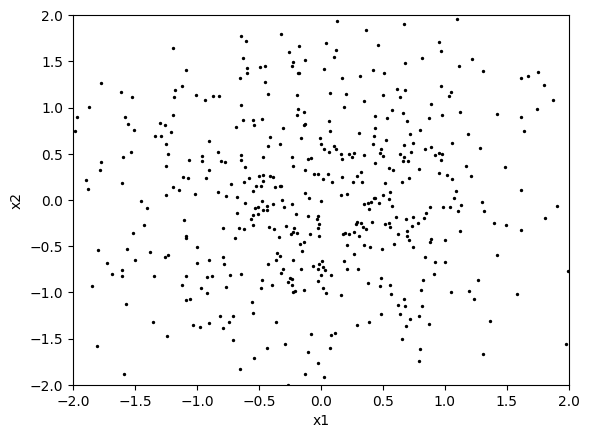

In [20]:
num_perturb = 500
X_lime = np.random.normal(0,1,size=(num_perturb,X.shape[1]))

set_plot_style()
plt.scatter(X_lime[:,0],X_lime[:,1],s=2,c="black")
plt.savefig('LIME_simplified_4.png')
plt.show()

### Pas 2: Utilitzar el classificador d'aprenentatge automàtic per predir les classes del nou conjunt de dades generat
El classificador RF entrenat en els passos anteriors s'utilitza aquí per predir la classe de cada parella (x1, x2) en el nou conjunt de dades generat.

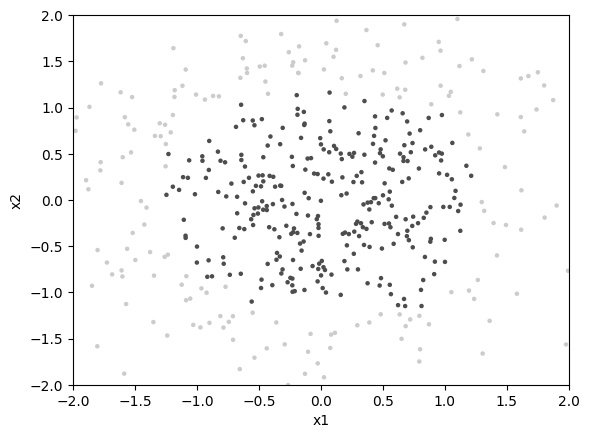

In [21]:
y_lime = classifier.predict(X_lime)
set_plot_style()
plt.scatter(X_lime[:,0],X_lime[:,1],s=5, c=y_lime, cmap=gray_cmap)
plt.savefig('LIME_simplified_5.png')
plt.show()

In [10]:
classifier.predict(np.array([0.8,-0.7]).reshape(1, -1) )


array([0])

### Pas 3: Calcular les distàncies entre la instància a explicar i cada pertorbació i calcular els pesos (importància) de les instàncies generades
Es calcula la distància entre cada instància generada aleatòriament i la instància que s'està explicant utilitzant la distància euclidiana. Per a explicacions d'altres tipus de dades, com ara imatges o dades de text, es pot utilitzar la distància del cosinus. Aquestes distàncies es mapegen després a un valor entre zero i un (pes) mitjançant una funció de nucli. Depenent de com configurem l'amplada del nucli, es mostra quan ample definim la "localitat" al voltant de la nostra instància. Per a dades tabulars, la definició de l'amplada del nucli requereix atenció especial, especialment si les dades no s'han estandarditzat. Una discussió més detallada sobre aquest tema de l'amplada del nucli es pot trobar al llibre ["Interpretable Machine Learning" de Christoph Molnar](https://christophm.github.io/interpretable-ml-book/) a la secció 5.7 o en el meu TFG. En el codi següent, es mostra la forma dels pesos i es pot observar que per a cada instància en el nou conjunt de dades generat aleatòriament, hi ha un valor de pes o importància corresponent.

In [22]:
kernel_width = 0.2
distances = np.sum((Xi - X_lime)**2,axis=1) #Euclidean distance
weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2))) #Kernel function
weights.shape

(500,)

El gràfic següent mostra com seria aquests pesos al voltant de la instància que s'està explicant. Els marcadors verds representen pesos més grans o instàncies amb major importància.

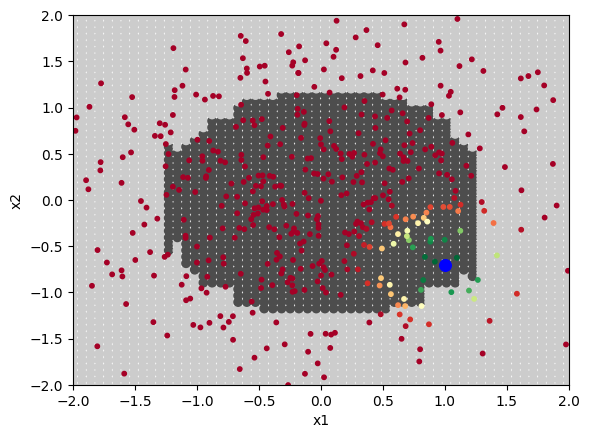

In [12]:
set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(X_lime[:,0],X_lime[:,1],s=10,c= weights,cmap="RdYlGn")
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )
plt.savefig('LIME_simplified_6.png')
plt.show()

### Pas 4: Utilitzar el nou conjunt de dades generat (`X_lime`), les seves prediccions de classe (`y_lime`) i la seva importància (`weights`) per ajustar un model més simple i interpretable (lineal)
S'ajusta un model lineal com es mostra a continuació. Aquest model lineal genera noves fronteres de decisió que són localment fidel al voltant de la instància explicada. Aquesta frontera de decisió lineal es pot veure amb els marcadors amb el símbol + i -. És important destacar que aquesta nova frontera de decisió lineal no és globalment fidel perquè es suposa que és un discriminador adequat només a la localitat de la instància que s'està explicant  (punt blau). Això és degut a que LIME és una interpretació del model a través d'un model surrogat (en aquest cas regressió lineal), intrínsecament interpretable, d'un model RF que és NO interpretable.

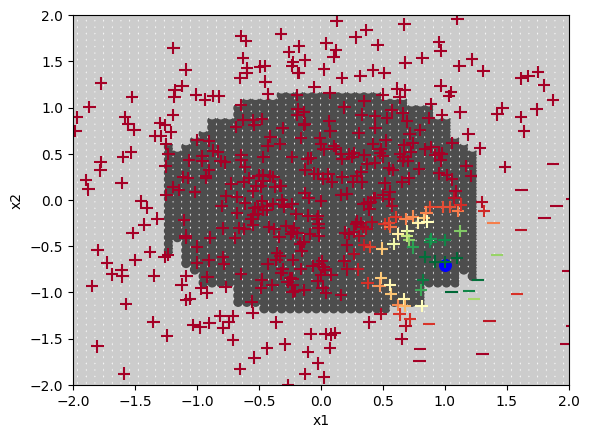

In [13]:
from sklearn.linear_model import LinearRegression
simpler_model = LinearRegression()
simpler_model.fit(X_lime, y_lime, sample_weight=weights)
y_linmodel = simpler_model.predict(X_lime)
y_linmodel = y_linmodel < 0.5 #Conver to binary class

set_plot_style()
plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )
plt.scatter(X_lime[y_linmodel==0,0],X_lime[y_linmodel==0,1],c= weights[y_linmodel==0],cmap="RdYlGn",marker="_",s=80)
plt.scatter(X_lime[y_linmodel==1,0],X_lime[y_linmodel==1,1],c= weights[y_linmodel==1],cmap="RdYlGn",marker="+",s=80)
plt.savefig('LIME_simplified_7.png')
plt.show()

Els coeficients d'aquest model lineal estimat es poden utilitzar per entendre com els canvis en les variables explicatives afecten la sortida de classificació per a la instància que s'està explicant. Per exemple, com es mostra a continuació, els coeficients estimats suggereixen que per a la instància que s'està explicant, augmentar els valors de x1 i disminuir el valor x2 farà que la predicció es decanti cap a la predicció de la classe negativa (àrea més fosca).

In [28]:
print(f"El model simplificat, té els següents coeficinets:  {simpler_model.coef_}")

El model simplificat, té els següents coeficinets:  [ 1.01335841 -0.48442315]


En aquest quadern, hem estudiat els conceptes bàsics de com funciona LIME per a dades tabulars. Els conceptes tractats aquí es poden transferir fàcilment a explicacions d'altres tipus de dades, com ara dades de text i imatges.

#### Visualitzacions de punts concrets

In [29]:
from sklearn.linear_model import LinearRegression

# Per obtenir diverses visualitzacions de forma més ràpida
def plot_LIME(point = [1,-0.7]):

  Xi = np.array(point)
  num_perturb = 500
  X_lime = np.random.normal(0,1,size=(num_perturb,X.shape[1]))
  y_lime = classifier.predict(X_lime)
  classifier.predict(np.array(point).reshape(1, -1) )
  kernel_width = 0.2
  distances = np.sum((Xi - X_lime)**2,axis=1) #Euclidean distance
  weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2))) #Kernel function

  simpler_model = LinearRegression()
  simpler_model.fit(X_lime, y_lime, sample_weight=weights)
  y_linmodel = simpler_model.predict(X_lime)
  y_linmodel = y_linmodel < 0.5 #Conver to binary class

  set_plot_style()
  plt.scatter(XX[:,0],XX[:,1], c=yy, cmap=gray_cmap)
  plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )
  plt.scatter(X_lime[y_linmodel==0,0],X_lime[y_linmodel==0,1],c= weights[y_linmodel==0],cmap="RdYlGn",marker="_",s=80)
  plt.scatter(X_lime[y_linmodel==1,0],X_lime[y_linmodel==1,1],c= weights[y_linmodel==1],cmap="RdYlGn",marker="+",s=80)
  plt.savefig('LIME_simplified_result.png')
  plt.show()
  print(f"Point {point} ---> {simpler_model.coef_}")
  return

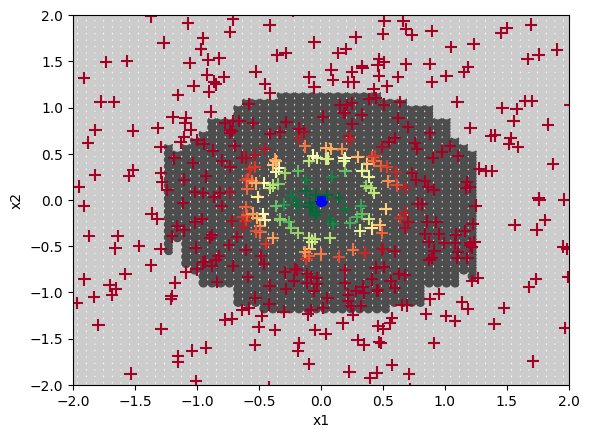

Point [0, 0] ---> [-8.12998518e-14  5.54593564e-13]


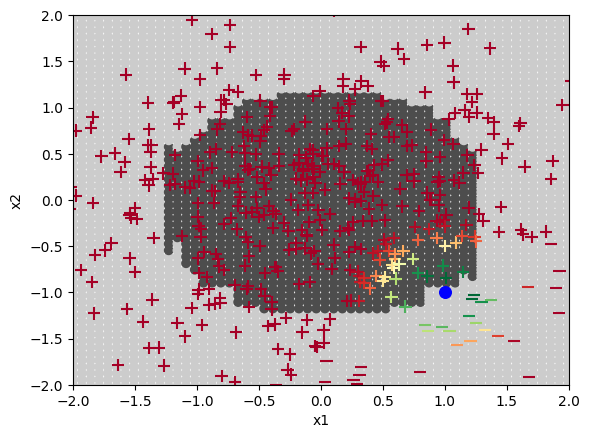

Point [1, -1] ---> [ 0.76134195 -1.04319023]


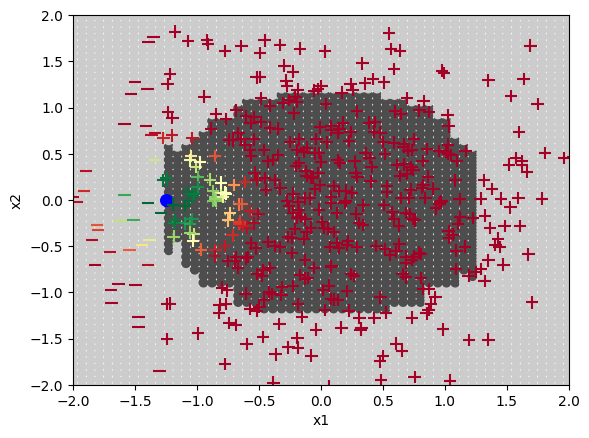

Point [-1.25, 0] ---> [-1.35775004 -0.00801541]


In [30]:
for i in [[0,0],[1,-1],[-1.25,0]]:
  plot_LIME(i)